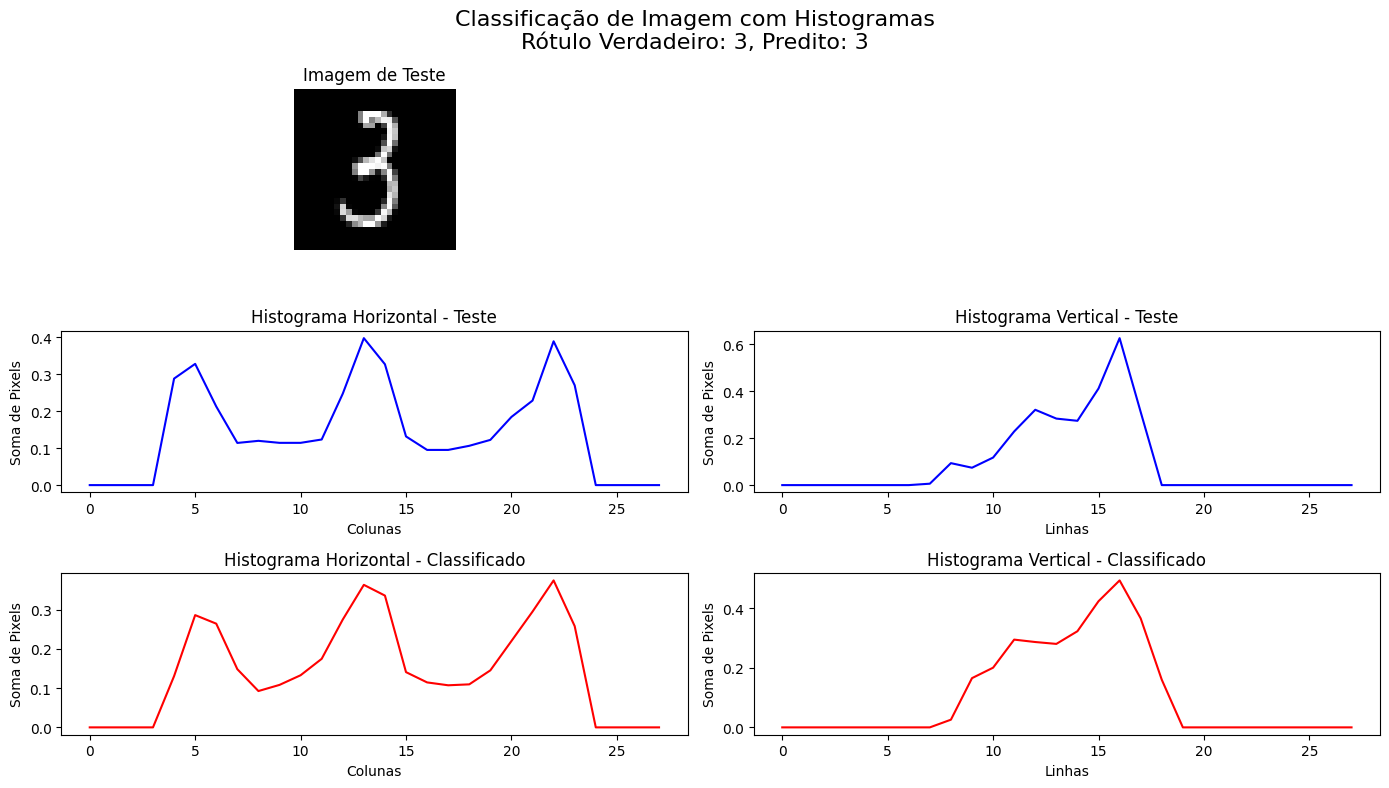

Acurácia do classificador baseado em histogramas: 88.00%


In [2]:
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import cv2
from sklearn.datasets import fetch_openml

def calculate_histograms(img):
    """
    Calcula os histogramas horizontal e vertical de uma imagem.
    """
    img = cv2.resize(img, (28, 28))
    vertical_hist = np.sum(img, axis=0).astype(np.float32)
    vertical_hist /= (np.linalg.norm(vertical_hist) + 1e-5)
    horizontal_hist = np.sum(img, axis=1).astype(np.float32)
    horizontal_hist /= (np.linalg.norm(horizontal_hist) + 1e-5)
    return vertical_hist, horizontal_hist

def compare_histograms(hist1, hist2):
    return euclidean(hist1, hist2)

def create_histogram_database(images, labels):
    histograms = {}
    for img, label in zip(images, labels):
        vertical_hist, horizontal_hist = calculate_histograms(img)
        if label not in histograms:
            histograms[label] = []
        histograms[label].append((vertical_hist, horizontal_hist))
    return histograms

def classify_image(test_img, histogram_database):
    test_vertical_hist, test_horizontal_hist = calculate_histograms(test_img)
    best_label = None
    lowest_distance = float('inf')
    best_vertical_hist = None
    best_horizontal_hist = None

    for label, hist_list in histogram_database.items():
        for vertical_hist, horizontal_hist in hist_list:
            vertical_distance = compare_histograms(test_vertical_hist, vertical_hist)
            horizontal_distance = compare_histograms(test_horizontal_hist, horizontal_hist)
            total_distance = vertical_distance + horizontal_distance
            if total_distance < lowest_distance:
                lowest_distance = total_distance
                best_label = label
                best_vertical_hist = vertical_hist
                best_horizontal_hist = horizontal_hist

    return best_label, test_vertical_hist, test_horizontal_hist, best_vertical_hist, best_horizontal_hist

# Carregar o dataset MNIST
mnist = fetch_openml('mnist_784', version=1)
data = mnist.data
labels = mnist.target.astype(int)
labels = labels.to_numpy()
images = data.values.reshape(-1, 28, 28).astype(np.uint8)

# Criar base de histogramas
train_images = images[:6000]
train_labels = labels[:6000]
histogram_database = create_histogram_database(train_images, train_labels)

# Selecionar imagem aleatória para teste
test_images = images[6000:6100]
test_labels = labels[6000:6100]
random_index = np.random.randint(0, len(test_images))
random_image = test_images[random_index]
random_label = test_labels[random_index]

# Classificar a imagem aleatória
prediction, test_vertical_hist, test_horizontal_hist, best_vertical_hist, best_horizontal_hist = classify_image(random_image, histogram_database)

# Plotar imagem, histogramas da imagem de teste e do melhor match
plt.figure(figsize=(14, 8))
plt.suptitle(f"Classificação de Imagem com Histogramas\nRótulo Verdadeiro: {random_label}, Predito: {prediction}", fontsize=16)

# Imagem original
plt.subplot(3, 2, 1)
plt.imshow(random_image, cmap='gray')
plt.title("Imagem de Teste")
plt.axis('off')

# Histograma Horizontal da Imagem de Teste
plt.subplot(3, 2, 3)
plt.plot(test_horizontal_hist, label="Horizontal - Teste", color='blue')
plt.title("Histograma Horizontal - Teste")
plt.xlabel("Colunas")
plt.ylabel("Soma de Pixels")

# Histograma Vertical da Imagem de Teste
plt.subplot(3, 2, 4)
plt.plot(test_vertical_hist, label="Vertical - Teste", color='blue')
plt.title("Histograma Vertical - Teste")
plt.xlabel("Linhas")
plt.ylabel("Soma de Pixels")

# Histograma Horizontal do Melhor Match
plt.subplot(3, 2, 5)
plt.plot(best_horizontal_hist, label="Horizontal - Classificado", color='red')
plt.title("Histograma Horizontal - Classificado")
plt.xlabel("Colunas")
plt.ylabel("Soma de Pixels")

# Histograma Vertical do Melhor Match
plt.subplot(3, 2, 6)
plt.plot(best_vertical_hist, label="Vertical - Classificado", color='red')
plt.title("Histograma Vertical - Classificado")
plt.xlabel("Linhas")
plt.ylabel("Soma de Pixels")

plt.tight_layout()
plt.show()

# Avaliar precisão
correct_predictions = 0
for i in range(100):
    prediction, _, _, _, _ = classify_image(test_images[i], histogram_database)
    if prediction == test_labels[i]:
        correct_predictions += 1

accuracy = correct_predictions / 100
print(f"Acurácia do classificador baseado em histogramas: {accuracy * 100:.2f}%")

